### Alunos
- Alexandre Candido Souza
- Klarissa Andrade de Morais

# Introdução

In [692]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import silhouette_score



plt.style.use('default')

trainData = pd.read_csv('./input/titanic_unsupervised.csv',index_col=0)


Os dados seguiam o seguinte formato:

| Variável | Definição | Valores |
|---|---|---|
| Pclass | Classe do Bilhete | 1 \| 2 \| 3 |
| Sex | Sexo | "male" \| "female" |
| Age | Idade | Anos (fracional se menor que 1)|
| Sibsp | Qtd de irmãos/conjugues a bordo |  |
| Parch | Qtd de pais/filhos a bordo |  |
| Ticket | Numero do Ticket |  |
| Fare | Taxa de passagem |  |
| Cabin | Numero da Cabine |  |
| Embarked | Porto de Embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

Percebemos que háviam muitas idades inválidas. É importante saber quantas e se outras colunas também estavam com dados faltando, e se for o caso, trata-los

In [693]:
print("Training DataSet:")
print(trainData.isna().sum())

Training DataSet:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Usamos o `InterativeImputer` do `Scikit`, que basicamente tenta aproximar o valor que está faltando na coluna idade à partir das outras 2 colunas, iterando recursivamente até chegar em um valor que talvez seja próximo do valor real, podemos parametrizar ele mais, mas deixamos no comportamento padrão.  
> Existem outros métodos de se imputar valores como o `SimpleImputer`, ou simplesmente tentar fazer uma média, moda ou mediana para preencher os valores que estão faltando. Mas no nosso caso o InterativeImputer funcionou bem.

qtd de idades inválidas: 0


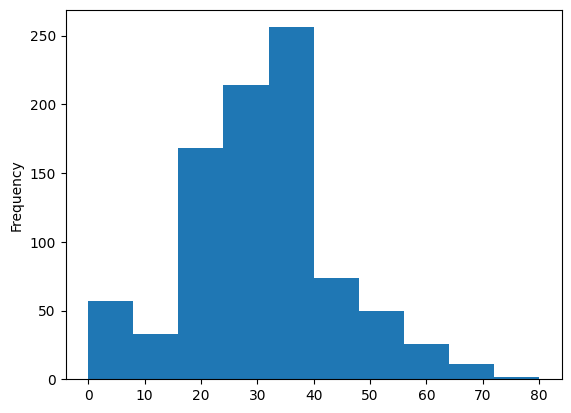

In [694]:
columns = ["SibSp", "Parch", "Age"]
imputer = IterativeImputer(min_value = 0)

imputedValues = imputer.fit_transform(trainData[columns])
correctedValues = pd.DataFrame(imputedValues, columns=columns)
trainData["Age"] = correctedValues["Age"]

trainData["Age"].plot(kind='hist')
print(f"qtd de idades inválidas: {trainData['Age'].isna().sum()}")

Para conseguir plotar o gráfico corretamnete, tem algumas colunas que precisam ser modificadas, pois não estão em valores númericos

In [695]:
#Valores faltando na taxa de embarque => média
trainData["Fare"] = trainData["Fare"].replace(np.NaN, trainData["Fare"].mean())
#converter em valores numéricos
trainData["Sex"] = trainData["Sex"].map({"male": 0, "female": 1})
trainData["Embarked"] = trainData["Embarked"].map({"C": 0, "Q": 1, "S": 2})

#removo qualquer NaN remanescente.
trainData["Cabin"] = trainData["Cabin"].fillna(0)
trainData = trainData.dropna().reset_index(drop=True)
trainData = trainData.drop(["Name", "Ticket", "Cabin", "PassengerId"], axis=1)
trainData.describe()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,0.350956,29.711080,0.524184,0.382452,32.096681,1.535433
std,0.834700,0.477538,13.306641,1.103705,0.806761,49.697504,0.792088
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,1.000000
50%,3.000000,0.000000,30.000000,0.000000,0.000000,14.454200,2.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


Criamos essa coluna temporaria "FamilyCount" somando a qtd de filhos e de conjugues ao passageiro
O dado mais relevante é saber se o passageiro está sozinho ou não. Por isso só ele é mantido

In [696]:
trainData["FamilyCount"] = trainData['SibSp'] + trainData['Parch'] + 1
trainData['IsAlone'] = trainData["FamilyCount"] == 1

trainData = trainData.drop(["SibSp","Parch",'FamilyCount'], axis=1)

## Visualizando a Distribuição dos Dados
Após todos os processos de tratamento, temos os parametros finais a ser utilizado pelo algoritmo. Agora, iremos visualizar brevemente a nova distribuição dos dados de custo que foram mapeados:

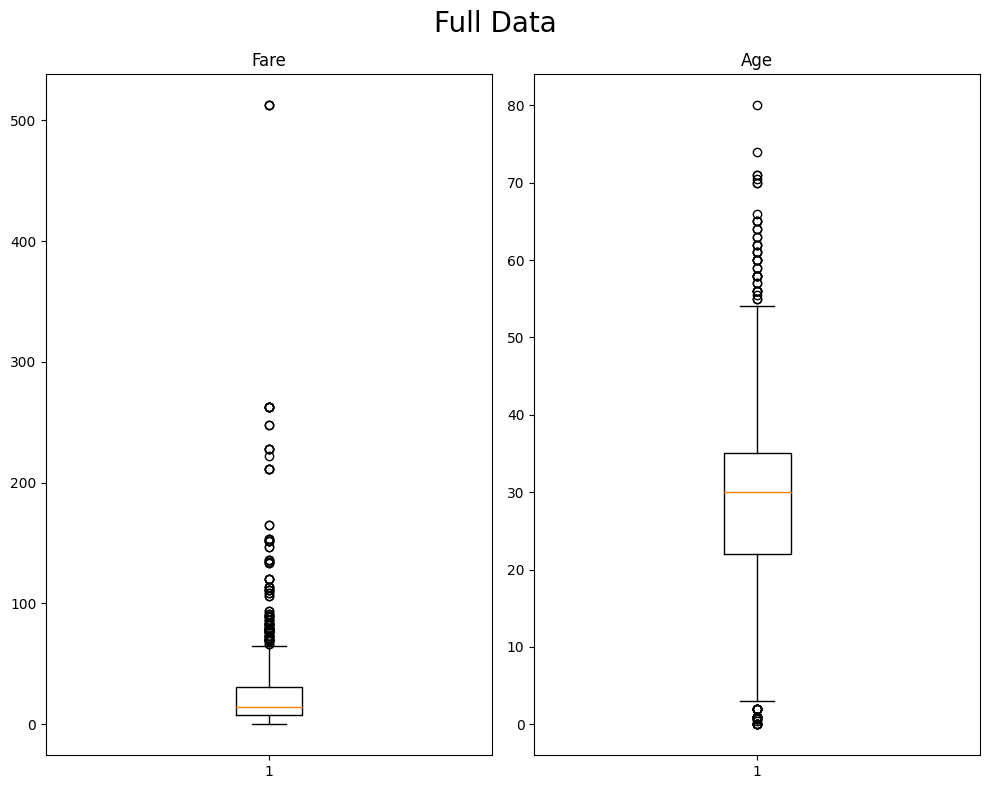

In [697]:
params = ["Fare", "Age"]
count = len(params)
width = 2
height = int(count/width)
figure, axis = plt.subplots(height, width, figsize=(10, 8))
figure.suptitle("Full Data", fontsize=20)

for i,attr in enumerate(params):
    values = trainData[attr].astype(float)
    axis[i].boxplot(values)
    axis[i].set_title(attr)

plt.tight_layout()
plt.show()

Percebemos que existem valores bem distantes no atributo "Fare". Como estão em pouquissima quantidade, nós resolvemos remover-los para manter a consistência

In [698]:
trainData = trainData.drop(trainData[trainData["Fare"] > 200].index)

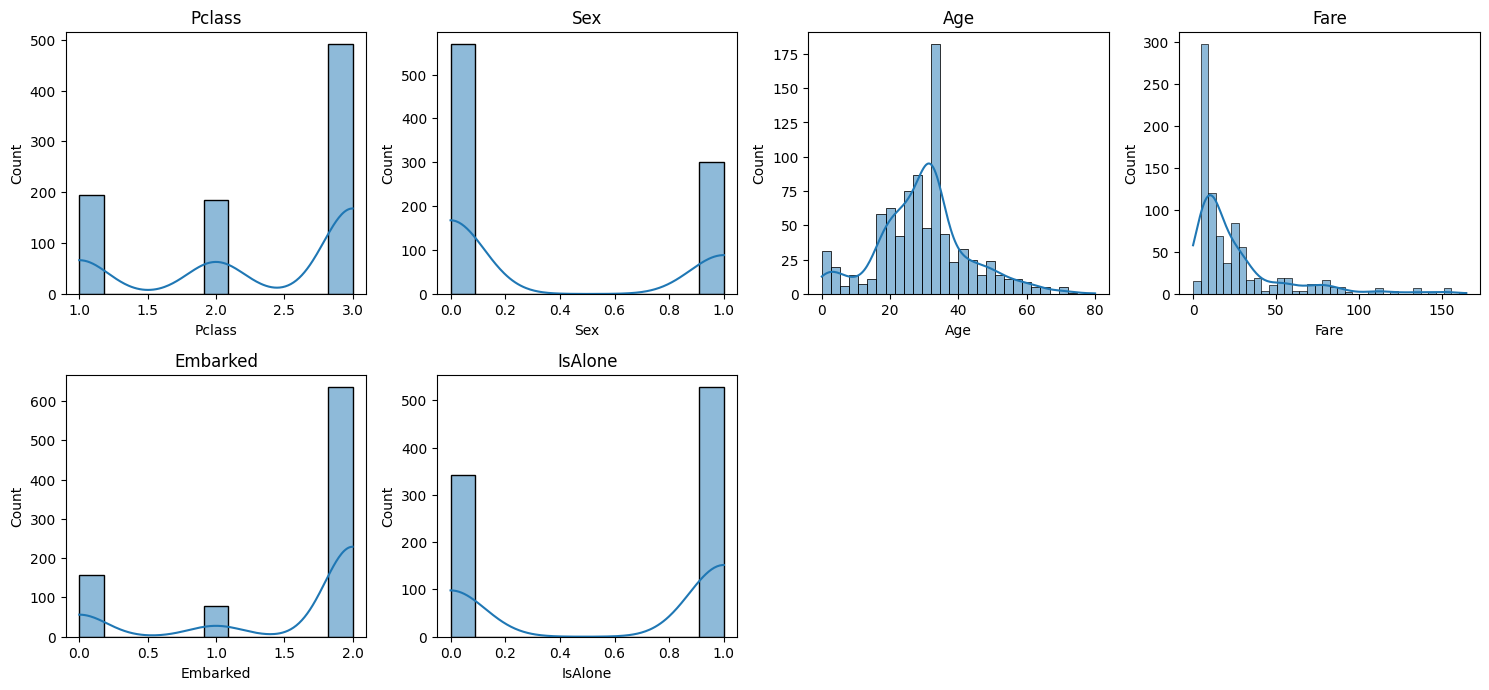

In [699]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(trainData.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(trainData[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


## Normalizando os dados
Normalizamos os dados do conjunto de dados para garantir que os algoritmos de clusterização, que dependem fortemente da distância entre os centroides, não sejam distorcidos por valores extremos. Ao transformar as características em uma escala comum, cada uma contribui igualmente para a distância entre os centroides, assegurando uma análise mais equilibrada e precisa.

In [700]:
trainData = pd.DataFrame(normalize(trainData, axis=0), columns=trainData.columns)
trainData.head()

,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0.041019,0.000000,0.022942,0.006240,0.039066,0.000000
1,0.013673,0.057735,0.039627,0.061357,0.000000,0.000000
2,0.041019,0.057735,0.027113,0.006821,0.039066,0.043519
3,0.013673,0.057735,0.036499,0.045705,0.039066,0.000000
4,0.041019,0.000000,0.036499,0.006929,0.039066,0.043519


## Escolhendo a quantidade de Clusters

Quando realizamos análise de cluster, uma etapa crítica é determinar o número apropriado de clusters em que os dados devem ser divididos.  


O método Elbow procura encontrar um equilíbrio entre a máxima compactação interna dos clusters e a mínima quantidade de clusters, identificando um ponto onde adicionar mais clusters não resulta em um ganho significativo na inércia, que é a soma das distâncias ao quadrado das amostras para o centro do cluster mais próximo. Por outro lado, o índice Silhouette avalia a qualidade dos clusters medindo o quão semelhante um objeto é ao seu próprio cluster em comparação a outros clusters. Usar ambos os métodos pode dar uma visão mais completa e possibilitar uma decisão mais informada sobre o número de clusters a serem utilizados na análise.

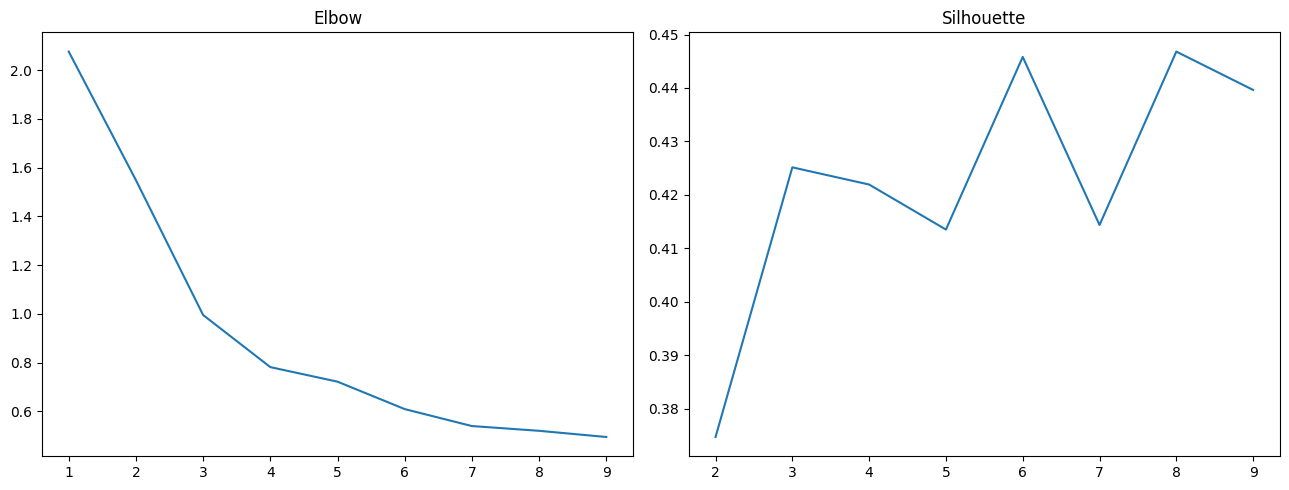

In [701]:

k_range = list(range(1, 10))
scores = {"elbow": [], "silhouette": []}

for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(trainData)
    scores["elbow"].append([i, kmeans.inertia_])
    if i == 1: continue
    scores["silhouette"].append([i, silhouette_score(trainData, kmeans.labels_)])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for i, (score_name, score_data) in enumerate(scores.items()):
    score_data = np.array(score_data)
    axes[i].plot(score_data[:, 0], score_data[:, 1])
    axes[i].set_title(score_name.capitalize())

plt.tight_layout()
plt.show()


Levando em consideração ambos os métodos, parece que não há um ponto óbvio e claro para o número de clusters. O método do elbow mostra uma possível escolha em k=3, enquanto o índice Silhouette sugere que a qualidade dos clusters melhora à medida que se aumenta o número de clusters, chegando até k=10. No entanto, escolher um valor de k muito alto pode não ser prático ou interpretável no contexto dos dados.

Uma abordagem sensata seria escolher um valor de k que seja grande o suficiente para capturar a estrutura dos dados, mas ainda pequeno o suficiente para ser interpretável e significativo. Com base no índice Silhouette, podemos optar por um valor intermediário como k=6, que mostra um bom equilíbrio entre a qualidade dos clusters e a parcimônia do modelo. Isso também evita a complexidade desnecessária que viria com a escolha do número máximo avaliado de k=10

## K-Means

O K-means é um popular algoritmo de aprendizado de máquina para clusterização que agrupa os dados em K número de clusters. O objetivo é minimizar a variação dentro de cada cluster e maximizar a variação entre clusters. Cada cluster no K-means é representado pelo seu centroide, que é a média de todos os pontos atribuídos ao cluster.

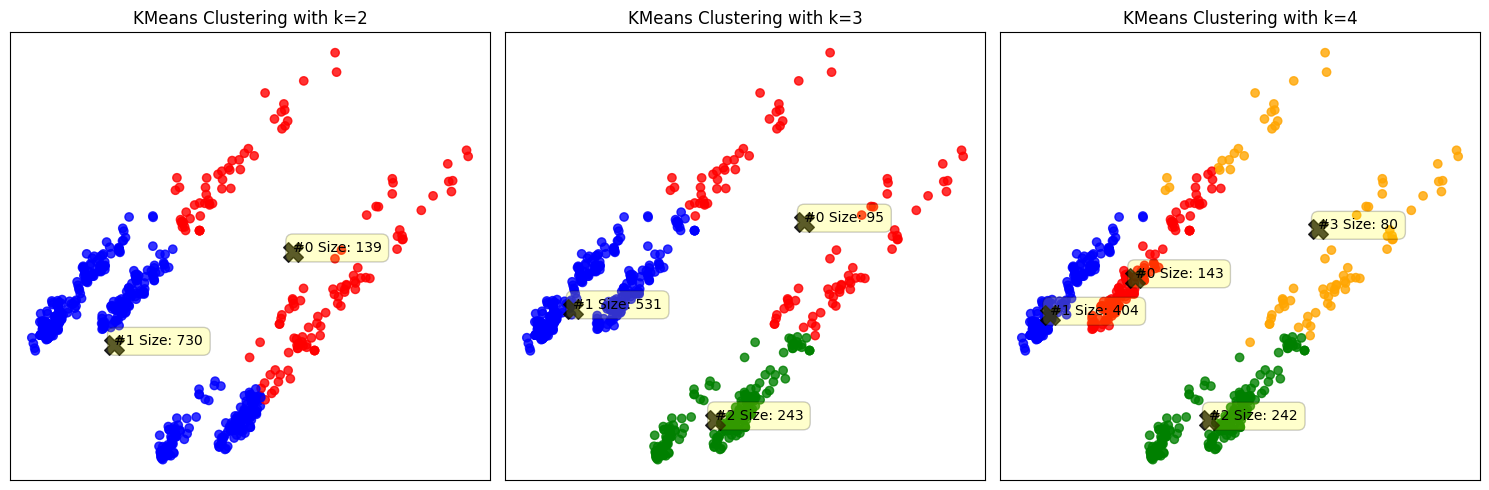

In [702]:
k_values = [2, 3, 4]
k_colors = ['red', 'blue', 'green', 'orange', 'pink', 'purple', 'brown'];

# Determine the number of rows and columns based on the length of k_values
num_cols = min(len(k_values), 3)
num_rows = (len(k_values) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
colors = np.array(k_colors)

for i, k in enumerate(k_values):
    row = i // num_cols
    col = i % num_cols
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(trainData)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(trainData.values)

    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[kmeans.labels_], alpha=0.8)
    ax.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
               c='black', s=200, alpha=0.8, marker='X')
    ax.set_title(f'KMeans Clustering with k={k}')
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    cluster_sizes = [np.sum(kmeans.labels_ == j) for j in range(k)]    
    # Annotate cluster sizes
    for cluster_id, cluster_center in enumerate(pca.transform(kmeans.cluster_centers_)):
        ax.annotate(
            f'#{cluster_id} Size: {cluster_sizes[cluster_id]}',
            xy=(cluster_center[0], cluster_center[1]),
            xycoords='data',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2)
        )



# Hide any empty subplots
for i in range(len(k_values), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Neste gráfico, exploramos a aplicação do algoritmo K-means em diferentes números de clusters (k). 

Utilizamos uma análise de componentes principais (PCA) para reduzir a dimensionalidade dos dados para visualização em duas dimensões.Cada subplot representa um número diferente de clusters (k), variando de 2 a 7.

Esta visualização nos ajuda a entender como a escolha do número de clusters afeta a estrutura dos grupos identificados pelo algoritmo K-means, fornecendo insights valiosos sobre a estrutura subjacente dos nossos dados e potencialmente auxiliando em futuras análises e tomadas de decisão.

## Analisando cada Cluster

Com os gráficos ácima podemos ver como os clusters estão distribuidos. Mas também é interessante analisar o que caracteristica cada cluster. Podemos exibir as médias de cada valor assim:

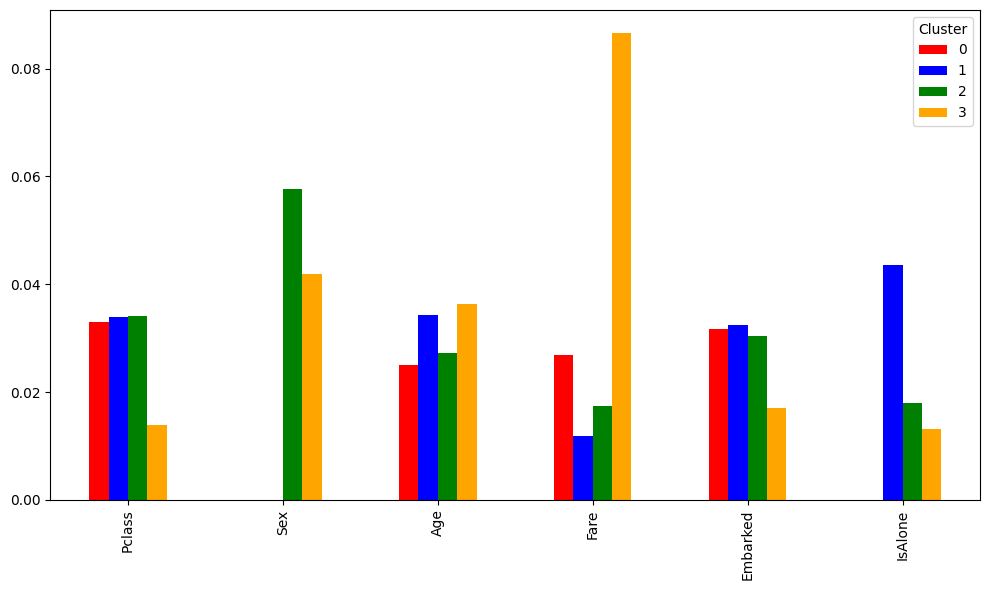

In [703]:
# Atribuir os rótulos dos clusters aos dados
trainData['Cluster'] = kmeans.labels_

# Calcular as médias de cada variável por cluster
cluster_means = trainData.groupby('Cluster').mean()
cluster_means_transposed = cluster_means.T

fig, ax = plt.subplots(figsize=(10, 6))
cluster_means_transposed.plot(kind='bar',ax=ax, color=colors)

plt.tight_layout()
plt.show()

### Cluster 0:
- **Número de Passageiros:** 143
- **Sexo:** Todos masculinos
- **Classe:** Principalmente segunda e terceira classe
- **Tarifa Média:** Moderada
- **Viajando Sozinho:** Nenhum

### Cluster 1:
- **Número de Passageiros:** 404
- **Sexo:** Todos masculinos
- **Classe:** Principalmente segunda e terceira classe
- **Tarifa Média:** Relativamente baixa
- **Viajando Sozinho:** A maioria

### Cluster 2:
- **Número de Passageiros:** 242
- **Sexo:** Principalmente feminino
- **Classe:** Principalmente segunda e terceira classe
- **Tarifa Média:** Moderada
- **Viajando Sozinho:** Menos que o Cluster 1

### Cluster 3:
- **Número de Passageiros:** 80
- **Sexo:** Predominantemente feminino
- **Classe:** Todos primeira classe
- **Tarifa Média:** Alta
- **Viajando Sozinho:** A menor parte


# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN é um algoritmo de clusterização baseado em densidade que pode identificar clusters de forma arbitrária em dados com ruído. Ele funciona com base em dois parâmetros: eps (epsilon), que define o raio de vizinhança, e minPts, o número mínimo de pontos necessários para formar um cluster denso. O DBSCAN segue os seguintes passos:

Para cada ponto de dado, se o ponto tem minPts dentro de um raio eps, um cluster é iniciado.

Expandir o Cluster: Para cada novo ponto dentro do cluster, verifica-se se também cumpre o critério de densidade (minPts dentro de eps). Se sim, o ponto é adicionado ao cluster.

Ponto de ruído: Um ponto que não pertence a nenhum cluster denso é considerado ruído.

Número estimado de clusters: 27
Número estimado de pontos de ruído: 175


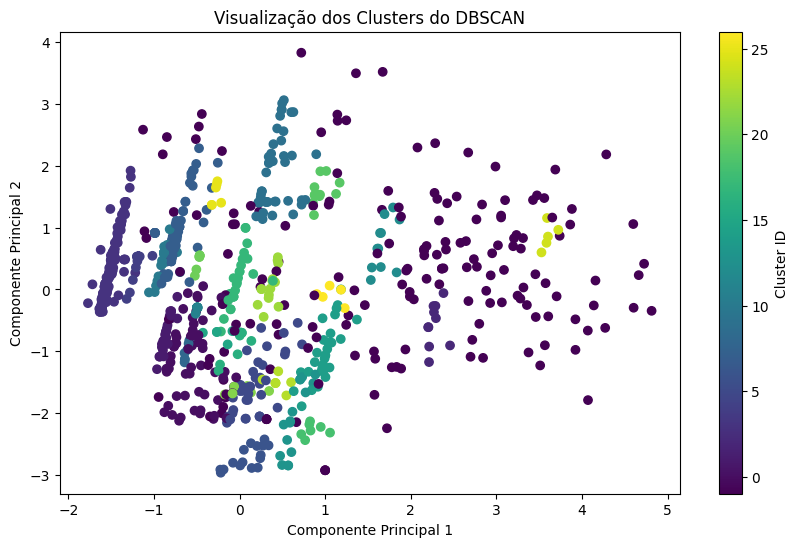

In [704]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

trainData_for_dbscan = trainData.drop('Cluster', axis=1)

scaler = StandardScaler()
trainData_scaled = scaler.fit_transform(trainData_for_dbscan)

eps_value = 0.5
min_samples_value = 5

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(trainData_scaled)

trainData['DBSCAN_Cluster'] = clusters

n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Número estimado de clusters: {n_clusters_}')
print(f'Número estimado de pontos de ruído: {n_noise_}')

pca = PCA(n_components=2)
trainData_pca = pca.fit_transform(trainData_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(trainData_pca[:, 0], trainData_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Visualização dos Clusters do DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster ID')
plt.show()


O gráfico PCA indica que há um número significativo de pontos classificados como ruído (pontos com rótulo -1), o que sugere que esses dados não se encaixam bem dentro dos critérios de densidade definidos pelos parâmetros eps e min_samples. Além disso, observamos que há seis clusters identificados (de 0 a 5), com uma distribuição variada de tamanhos.

Distribuição dos Clusters
O Cluster -1, representando ruído, tem 128 pontos. Isso é típico em conjuntos de dados com muita dispersão ou quando os parâmetros de DBSCAN não são bem ajustados ao contexto dos dados.
O Cluster 1 é o maior cluster significativo, com 36 pontos, indicando que esses pontos estão próximos uns dos outros e satisfazem os parâmetros de densidade escolhidos.
Os Clusters 2 a 5 são bem menores, com 6 a 12 pontos, o que pode indicar pequenas regiões de alta densidade no espaço de dados.

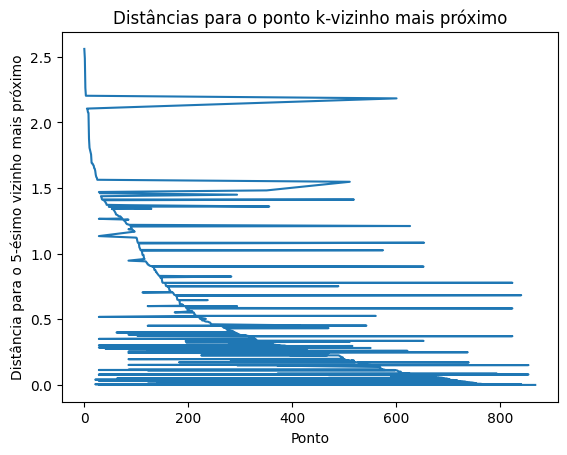

In [705]:
k = min_samples_value
nn = NearestNeighbors(n_neighbors=k)
neighbors = nn.fit(trainData_scaled)
distances, indices = neighbors.kneighbors(trainData_scaled)

distanceDec = sorted(distances[:, k-1], reverse=True)
plt.plot(indices[:, 0], distanceDec)
plt.xlabel('Ponto')
plt.ylabel(f'Distância para o {k}-ésimo vizinho mais próximo')
plt.title('Distâncias para o ponto k-vizinho mais próximo')
plt.show()

 A parte da curva antes de se estabilizar pode fornecer um bom valor para eps. Neste caso, não há um ponto de cotovelo nítido, mas parece que começa a se estabilizar em torno do índice 25. Isso pode sugerir um valor de eps em torno da distância correspondente no eixo y, que parece estar aproximadamente entre 1.5 e 2.0.

In [706]:
# Experimentação de valores de eps e min_samples
for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(3, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(trainData_scaled)
        n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise_ = list(clusters).count(-1)

        print(f'eps: {eps:.1f}, min_samples: {min_samples}, clusters: {n_clusters_}, noise: {n_noise_}')


eps: 0.1, min_samples: 3, clusters: 43, noise: 475
eps: 0.1, min_samples: 4, clusters: 24, noise: 536
eps: 0.1, min_samples: 5, clusters: 15, noise: 585
eps: 0.1, min_samples: 6, clusters: 12, noise: 603
eps: 0.1, min_samples: 7, clusters: 7, noise: 634
eps: 0.1, min_samples: 8, clusters: 7, noise: 637
eps: 0.1, min_samples: 9, clusters: 4, noise: 661
eps: 0.2, min_samples: 3, clusters: 51, noise: 318
eps: 0.2, min_samples: 4, clusters: 32, noise: 385
eps: 0.2, min_samples: 5, clusters: 22, noise: 442
eps: 0.2, min_samples: 6, clusters: 18, noise: 483
eps: 0.2, min_samples: 7, clusters: 13, noise: 521
eps: 0.2, min_samples: 8, clusters: 9, noise: 551
eps: 0.2, min_samples: 9, clusters: 8, noise: 569
eps: 0.3, min_samples: 3, clusters: 50, noise: 216
eps: 0.3, min_samples: 4, clusters: 38, noise: 264
eps: 0.3, min_samples: 5, clusters: 31, noise: 317
eps: 0.3, min_samples: 6, clusters: 26, noise: 355
eps: 0.3, min_samples: 7, clusters: 18, noise: 415
eps: 0.3, min_samples: 8, clusters: 

Com eps abaixo de 0.3, a maior parte dos pontos é considerada ruído.
À medida que eps aumenta para 0.5 e acima, começamos a ver um número mais equilibrado de clusters e uma redução significativa no ruído.
Valores de min_samples menores (por exemplo, 3) resultam em um número maior de clusters.

In [707]:
#Análise dos pontos classificados como ruído para um conjunto específico de parâmetros
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(trainData_scaled)

noise_indices = np.where(clusters == -1)[0]

noise_points = trainData.iloc[noise_indices]
print("Características dos pontos de ruído:")
print(noise_points.describe())

Características dos pontos de ruído:
           Pclass         Sex         Age        Fare    Embarked     IsAlone  \
count  175.000000  175.000000  175.000000  175.000000  175.000000  175.000000   
mean     0.021564    0.031342    0.034831    0.054796    0.020091    0.017656   
std      0.010807    0.028844    0.019446    0.036449    0.018781    0.021431   
min      0.013673    0.000000    0.000000    0.006219    0.000000    0.000000   
25%      0.013673    0.000000    0.021899    0.023357    0.000000    0.000000   
50%      0.013673    0.057735    0.033848    0.055948    0.019533    0.000000   
75%      0.027346    0.057735    0.050055    0.074454    0.039066    0.043519   
max      0.041019    0.057735    0.083425    0.141908    0.039066    0.043519   

          Cluster  DBSCAN_Cluster  
count  175.000000           175.0  
mean     1.897143            -1.0  
std      1.155070             0.0  
min      0.000000            -1.0  
25%      1.000000            -1.0  
50%      2.000000

In [708]:
cluster_counts = trainData['DBSCAN_Cluster'].value_counts()
print(cluster_counts)

# Análise dos clusters
for cluster in np.unique(clusters):
    if cluster != -1:  # Se não for ruído
        print(f"\nCluster {cluster} Statistics:")
        cluster_data = trainData[trainData['DBSCAN_Cluster'] == cluster]
        print(cluster_data.describe())

DBSCAN_Cluster
 3     193
-1     175
 7      62
 0      59
 9      43
 5      37
 10     31
 14     29
 1      27
 4      26
 17     25
 11     18
 13     17
 6      16
 22     14
 19     12
 12     11
 2      10
 16      8
 8       7
 18      7
 20      7
 21      7
 23      7
 25      6
 15      5
 24      5
 26      5
Name: count, dtype: int64

Cluster 0 Statistics:
             Pclass   Sex        Age       Fare   Embarked  IsAlone  Cluster  \
count  5.900000e+01  59.0  59.000000  59.000000  59.000000     59.0     59.0   
mean   4.101899e-02   0.0   0.021196   0.018326   0.039066      0.0      0.0   
std    1.399691e-17   0.0   0.013001   0.010162   0.000000      0.0      0.0   
min    4.101899e-02   0.0   0.001043   0.005591   0.039066      0.0      0.0   
25%    4.101899e-02   0.0   0.009385   0.011441   0.039066      0.0      0.0   
50%    4.101899e-02   0.0   0.020856   0.017186   0.039066      0.0      0.0   
75%    4.101899e-02   0.0   0.029478   0.024015   0.039066      0.0 

Cluster 0: Com a menor variação em todas as variáveis e um tamanho de cluster de apenas 8 pontos, este parece ser um grupo muito homogêneo. O valor da tarifa é mais elevado em comparação com outros clusters, o que pode sugerir que esses passageiros possuem características semelhantes e talvez sejam passageiros de classe superior.

Cluster 1: O maior cluster formado pelo DBSCAN, com 36 pontos. Este cluster tem uma distribuição mais uniforme das idades e uma baixa média de tarifas, o que pode indicar passageiros da terceira classe.

Cluster 2: Consiste em 12 pontos e apresenta uma variação maior de idades e tarifas do que o Cluster 0, mas ainda assim é um grupo relativamente pequeno e pode representar uma subcategoria específica de passageiros.

Clusters 3, 4, e 5: Todos esses clusters têm 6 pontos cada e são caracterizados por baixas médias de tarifas, o que pode indicar passageiros de classes econômicas. Eles têm variações mínimas em suas características, o que sugere uma grande homogeneidade dentro desses pequenos grupos.